In [76]:
import netCDF4 as nc
import xarray as xr

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import os

####### Variables ########

#Define path to folder
file_path = '/Users/miajanzen/Klima_HU/glacier_space/grid_analysis/nc_files'

grid_path_small = os.path.join(file_path, 'hef_51m_DOM07.nc')
#vars_path_small = os.path.join(file_path, 'LES_51m_ml_0002.nc') #ml file
vars_path_small = os.path.join(file_path, 'LES_51m_pl_0002.nc') # pl file
grid_path_large = os.path.join(file_path, 'hef_411m_DOM04.nc')
#vars_path_large = os.path.join(file_path, 'LES_411m_ml_0002.nc') #ml file
vars_path_large = os.path.join(file_path, 'LES_411m_pl_0002.nc') # pl file


var = 'w' # select variable
time_index = 4 # select time index
# For pl files select 0 = 500 PA and 1 = 750 PA
# For ml files select a height index between 0 to 151 eg. 0 to 91
height_index_small = 1 #150 
height_index_large = 1 #90

###########################

class ICONGrid:
    @staticmethod
    def save_as_gpkg(gdf, filename, layer):
        gdf.to_file(filename=filename, layer=layer, driver="GPKG")


    def __init__(self, grid_file, var_file):
        self.ds_grid = xr.open_dataset(grid_file)
        self.ds_vars = xr.open_dataset(var_file)
        
        if 'height' in self.ds_vars.sizes and 'height_2' in self.ds_vars.sizes:
            self.height_full = self.ds_vars.sizes['height']
            self.height_half = self.ds_vars.sizes['height_2']   
        elif 'plev' in self.ds_vars.sizes:
            self.plev = self.ds_vars.sizes['plev']
        else:
            raise ValueError('No height dimension found')
        
        try:
            grid_file_parts = grid_file.split('.')
            parent_file = f'{grid_file_parts[0]}.parent.{grid_file_parts[1]}'
            self.ds_parent = nc.Dataset(parent_file)
        except:
            print('Parent file not found.')

        self.cells = self.ds_grid.sizes['cell']
        self.gdf_triangles = self.__load_triangles()

    def __load_triangles(self):
        lat = self.ds_grid['clat_vertices'][:, :].data
        lon = self.ds_grid['clon_vertices'][:, :].data
        lon_centers = self.ds_grid["lon_cell_centre"][:]
        lat_centers = self.ds_grid["lat_cell_centre"][:]

        lat = np.rad2deg(lat)
        lon = np.rad2deg(lon)

        self.extent = {'lon_min':lon.min(),
                       'lat_min':lat.min(),
                       'lon_max':lon.max(),
                       'lat_max':lat.max(),}


        triangle_coordinates_list = []
        for i, item in enumerate(lat):
            triangle_coordinates_list.append([(lon[i][0], lat[i][0]), (lon[i][1], lat[i][1]), (lon[i][2], lat[i][2])])

        polygons = []
        for triangle_coords in triangle_coordinates_list:
            polygon = Polygon(triangle_coords)
            polygons.append(polygon)

        geometry = gpd.GeoSeries(polygons)
        gdf = gpd.GeoDataFrame(data=range(1, self.cells + 1), columns=['cell_id'], geometry=geometry, crs="EPSG:4326")
        
        # Add center coordinates
        gdf['clat'] = np.rad2deg(self.ds_grid['clat'][:].data)
        gdf['clon'] = np.rad2deg(self.ds_grid['clon'][:].data)

        center_points = [Point(lon, lat) for lon, lat in zip(np.rad2deg(lon_centers), np.rad2deg(lat_centers))]
        gdf['center_geom'] = center_points

        return gdf
    
    def get_triangles(self):
        return self.gdf_triangles
    
    def get_variable(self, param):
        return self.ds_vars[param][:].data



In [77]:
class ICONSelect:
    def __init__(self, grid_path, var_path, var_name, time_index=0, height_index=0):
        self.icon = ICONGrid(grid_path, var_path)
        self.gdf = self.icon.get_triangles()
        self.time = self.icon.ds_vars.coords["time"]
        self.height_dim = self._infer_height_dim(var_name)
        print(f"Using height dimension: {self.height_dim}")
        self.var_name = var_name
        self.time_index = time_index
        self.height_index = height_index
        print(F"height_index", self.height_index)

        self.data = self.icon.get_variable(var_name)
        
        data_slice = self.data[time_index, height_index, :]

        # Min/Max Values
        min_val = np.nanmin(data_slice)
        max_val = np.nanmax(data_slice)
        min_id = np.nanargmin(data_slice)
        max_id = np.nanargmax(data_slice)

        print(f"Variable '{var_name}' at time={time_index}, {self.height_dim}={height_index}")
        print(f"  ➤ Min: {min_val:.4f} at cell_id={min_id}")
        print(f"  ➤ Max: {max_val:.4f} at cell_id={max_id}")
        
        self.xr = xr.Dataset(
            {
                var_name: (["time", self.height_dim, "cell"], self.data)
            },
            coords={
                "time": self.icon.ds_vars.coords["time"],
                self.height_dim: self.icon.ds_vars.coords[self.height_dim],
                "cell": np.arange(self.data.shape[2])
            }
        )

        self.xr = self.xr.assign_coords(
            center_lon=("cell", self.gdf["clon"].values),
            center_lat=("cell", self.gdf["clat"].values)
        )

    def _infer_height_dim(self, var_name):
        dims = self.icon.ds_vars[var_name].dims
        for d in dims:
            if d.startswith("height")or d == "plev":
                return d
        raise ValueError(f"No height dimension found for variable '{var_name}'")
    

    def get_slice_as_gdf(self):
        xr_slice = self.xr.isel(time=self.time_index, **{self.height_dim: self.height_index})
        values = xr_slice[self.var_name].values

        gdf_out = self.gdf.copy()
        gdf_out[self.var_name] = values
        return gdf_out
    
    def get_slice_as_gdf(self):
        xr_slice = self.xr.isel(time=self.time_index, **{self.height_dim: self.height_index})
        values = xr_slice[self.var_name].values

        gdf_out = self.gdf.copy()
        gdf_out[self.var_name] = values
        return gdf_out

    @staticmethod
    def get_relation(large_file, small_file, name_large="large", name_small="small"):
        centers = gpd.GeoDataFrame(
            small_file[["cell_id"]].copy(),
            geometry=small_file["center_geom"],
            crs=small_file.crs
        )

        joined = gpd.sjoin(
            centers,
            large_file[["cell_id", "geometry"]],
            predicate="within",
            how="inner"
        )

        joined = joined[["cell_id_left", "cell_id_right"]].rename(columns={
            "cell_id_left": f"cell_id_{name_small}",
            "cell_id_right": f"cell_id_{name_large}"
        })

        return joined

    @staticmethod
    def aggregate_to_large(gdf_small, gdf_large, relation_df, var_name, name_large="large", name_small="small"):
        relation_df = relation_df.rename(columns={
            f"cell_id_{name_small}": "cell_id",
            f"cell_id_{name_large}": f"cell_id_{name_large}"
        })
        merged = gdf_small.merge(relation_df[["cell_id", f"cell_id_{name_large}"]], on="cell_id", how="left")
        merged = merged[["cell_id", f"cell_id_{name_large}", var_name]]

        mean_values = merged.groupby(f"cell_id_{name_large}")[var_name].mean().reset_index()
        mean_values = mean_values.rename(columns={var_name: f"mean_{var_name}"})

        gdf_large_geom = gdf_large[["cell_id", "geometry"]].rename(columns={"cell_id": f"cell_id_{name_large}"})
        mean_with_geom = mean_values.merge(gdf_large_geom, on=f"cell_id_{name_large}", how="left")
        mean_with_geom = gpd.GeoDataFrame(mean_with_geom, geometry="geometry", crs="EPSG:4326")

        return mean_with_geom

    


In [78]:
select_small = ICONSelect(grid_path_small, vars_path_small,var, time_index=time_index, height_index=height_index_small)
xr_small_slice = select_small.get_slice_as_gdf()
print(xr_small_slice)


select_large = ICONSelect(grid_path_large, vars_path_large, var, time_index=time_index, height_index= height_index_large)
xr_large_slice = select_large.get_slice_as_gdf()
print(xr_large_slice)



Using height dimension: plev
height_index 1
Variable 'w' at time=4, plev=1
  ➤ Min: -6.2899 at cell_id=16622
  ➤ Max: 8.5486 at cell_id=83848
       cell_id                                           geometry       clat  \
0            1  POLYGON ((10.87023 46.73397, 10.87089 46.73454...  46.734370   
1            2  POLYGON ((10.87089 46.73454, 10.87156 46.73512...  46.734948   
2            3  POLYGON ((10.87054 46.73521, 10.86988 46.73463...  46.734801   
3            4  POLYGON ((10.87085 46.73645, 10.87019 46.73587...  46.736041   
4            5  POLYGON ((10.87054 46.73521, 10.8712 46.73578,...  46.735610   
...        ...                                                ...        ...   
88635    88636  POLYGON ((10.77576 46.7329, 10.7751 46.73232, ...  46.732493   
88636    88637  POLYGON ((10.77713 46.73215, 10.77779 46.73273...  46.732557   
88637    88638  POLYGON ((10.77677 46.73281, 10.77611 46.73224...  46.732410   
88638    88639  POLYGON ((10.77611 46.73224, 10.77677 46.7

/var/folders/ft/nvb6tnm57hj9p0zd3xgf0j8m0000gn/T/ipykernel_27993/3154123229.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  xr_large_slice_clipped = gpd.clip(xr_large_slice, mean_w.unary_union)


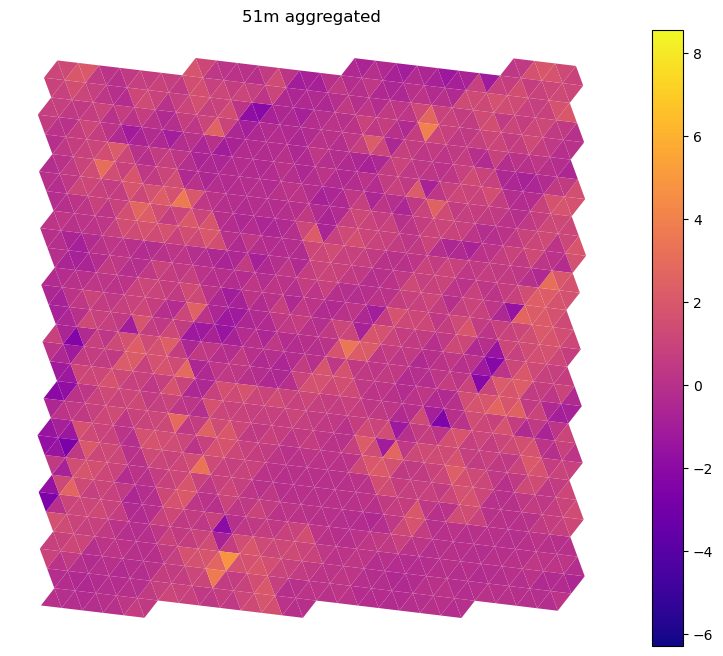

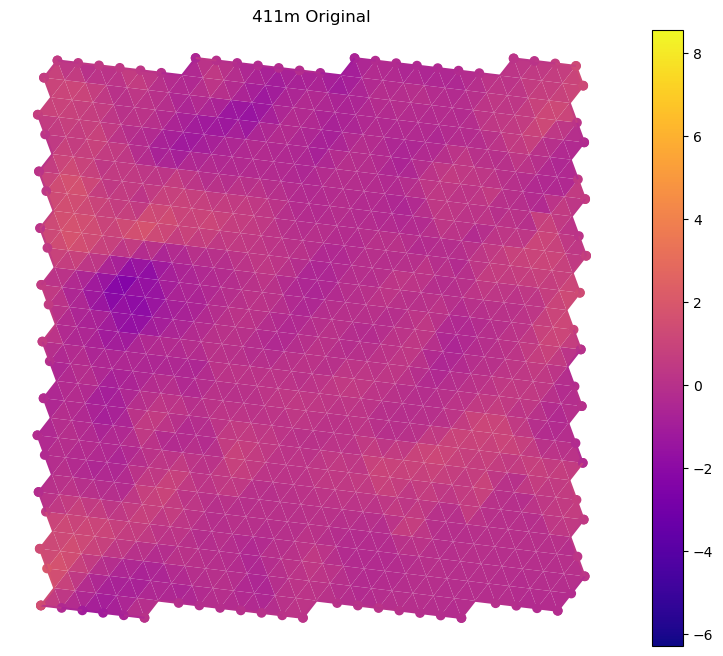

In [79]:
relation = ICONSelect.get_relation(
    large_file=xr_large_slice,
    small_file=xr_small_slice,
    name_large="411m",
    name_small="51m"
)

mean_w = ICONSelect.aggregate_to_large(
    gdf_small=xr_small_slice,
    gdf_large=xr_large_slice,
    relation_df=relation,
    var_name="w",
    name_large="411m",
    name_small="51m"
)
xr_large_slice_clipped = gpd.clip(xr_large_slice, mean_w.unary_union)

vmin = min(xr_small_slice["w"].min(), mean_w["mean_w"].min())
vmax = max(xr_small_slice["w"].max(), mean_w["mean_w"].max())

fig1, ax1 = plt.subplots(figsize=(10, 8))
mean_w.plot(column="mean_w", ax=ax1, legend=True, cmap="plasma", vmin=vmin, vmax=vmax)
ax1.set_title("51m aggregated")
ax1.axis("off")

fig2, ax2 = plt.subplots(figsize=(10, 8))
xr_large_slice_clipped.plot(column="w", ax=ax2, legend=True, cmap="plasma", vmin=vmin, vmax=vmax)
ax2.set_title("411m Original")
ax2.axis("off")

plt.show()

      cell_id                                           geometry       clat  \
0       10083  POLYGON ((10.80143 46.73205, 10.80427 46.72676...  46.728818   
1       10077  POLYGON ((10.79331 46.73272, 10.79615 46.72743...  46.729485   
2       10078  POLYGON ((10.79331 46.73272, 10.80143 46.73205...  46.730663   
3        9979  POLYGON ((10.81767 46.73072, 10.8205 46.72542,...  46.727481   
4       10085  POLYGON ((10.80955 46.73139, 10.81239 46.72609...  46.728150   
...       ...                                                ...        ...   
1463    15346  POLYGON ((10.81406 46.86762, 10.81121 46.87291...  46.870857   
1464    15344  POLYGON ((10.80591 46.86829, 10.80306 46.87358...  46.871527   
1465    15352  POLYGON ((10.8222 46.86695, 10.81935 46.87224,...  46.870186   
1466    15214  POLYGON ((10.86821 46.86821, 10.87351 46.87283...  46.869596   
1467    15197  POLYGON ((10.86006 46.86888, 10.85722 46.87418...  46.872120   

           clon                                    

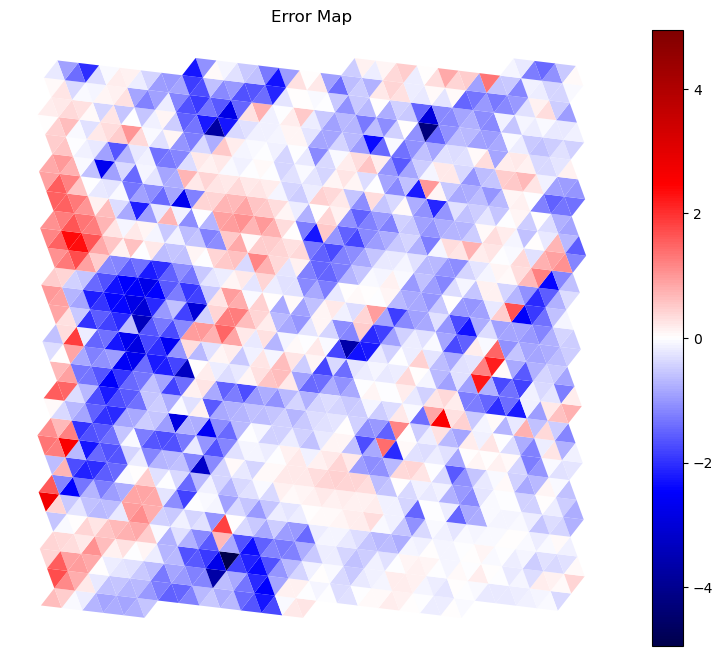

In [88]:
mean_w_renamed = mean_w.rename(columns={"cell_id_411m": "cell_id"})

diff_df = xr_large_slice_clipped.merge(
    mean_w_renamed [["cell_id", "mean_w"]],
    on="cell_id",
    how="inner"
)


diff_df["w_diff"] = diff_df["w"] - diff_df["mean_w"]

print(diff_df)

v = np.abs(diff_df["w_diff"]).max()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
diff_df.plot(column="w_diff", cmap="seismic", legend=True, ax=ax, vmin=-v, vmax=v)
ax.set_title("Error Map")
ax.set_axis_off()
plt.show()